# How ReLU Activation Enables Non-Linear Approximation

## 🎯 The Fundamental Question

**Question**: If forward propagation is just:

```
((X·W1 + b1)·W2 + b2)·W3 + b3 = X·(W1·W2·W3) + constants
```

This simplifies to `X·W_combined + b_combined` → **Still linear!**

**So how can a neural network learn quadratic functions like y = x²?**

---

## 📋 What This Notebook Demonstrates

1. **The Problem**: Why linear networks collapse to a single layer
2. **The Solution**: How ReLU activation prevents this collapse
3. **ReLU's Unique Properties**:
   - Piecewise linear nature
   - No saturation for positive values
   - Sparse activation patterns
4. **Visual Demonstrations**: See how ReLU creates non-linearity
5. **Universal Approximation**: How ReLU networks can learn any function

Let's dive in! 🚀

## 1. Setup and Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
NumPy version: 2.0.2


## 2. The Problem: Linear Networks Collapse

### Mathematical Proof

Consider a 2-layer network **WITHOUT** activation functions:

```
Layer 1: h1 = X·W1 + b1
Layer 2: h2 = h1·W2 + b2
Output:  y = h2·W3 + b3
```

Substituting:
```
h2 = (X·W1 + b1)·W2 + b2
   = X·W1·W2 + b1·W2 + b2

y = (X·W1·W2 + b1·W2 + b2)·W3 + b3
  = X·(W1·W2·W3) + (b1·W2·W3 + b2·W3 + b3)
  = X·W_combined + b_combined
```

**Result**: Still linear! Multiple layers = waste of computation! ❌

In [3]:
# Generate data: y = x²
X = np.linspace(-3, 3, 100).reshape(-1, 1)
y_true = X ** 2

# Add some noise
y_noisy = y_true + np.random.normal(0, 0.1, y_true.shape)

print(f"Generated {len(X)} data points for y = x²")
print(f"X range: [{X.min():.2f}, {X.max():.2f}]")
print(f"y range: [{y_true.min():.2f}, {y_true.max():.2f}]")

Generated 100 data points for y = x²
X range: [-3.00, 3.00]
y range: [0.00, 9.00]


### Demo 1: Linear Network (No Activations)

In [4]:
class LinearNetwork:
    """Network WITHOUT activation functions"""
    def __init__(self, learning_rate=0.01):
        self.lr = learning_rate
        self.W1 = np.random.randn(1, 1) * 0.1
        self.b1 = np.zeros((1, 1))
        self.W2 = np.random.randn(1, 1) * 0.1
        self.b2 = np.zeros((1, 1))
        self.W3 = np.random.randn(1, 1) * 0.1
        self.b3 = np.zeros((1, 1))
        
    def forward(self, X):
        self.h1 = X @ self.W1 + self.b1
        self.h2 = self.h1 @ self.W2 + self.b2
        self.y_pred = self.h2 @ self.W3 + self.b3
        self.X = X
        return self.y_pred
    
    def backward(self, y_true, y_pred):
        n = len(y_true)
        dL_dy = 2 * (y_pred - y_true) / n
        
        dL_dW3 = self.h2.T @ dL_dy
        dL_db3 = np.sum(dL_dy, axis=0, keepdims=True)
        
        dL_dh2 = dL_dy @ self.W3.T
        dL_dW2 = self.h1.T @ dL_dh2
        dL_db2 = np.sum(dL_dh2, axis=0, keepdims=True)
        
        dL_dh1 = dL_dh2 @ self.W2.T
        dL_dW1 = self.X.T @ dL_dh1
        dL_db1 = np.sum(dL_dh1, axis=0, keepdims=True)
        
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
        self.W3 -= self.lr * dL_dW3
        self.b3 -= self.lr * dL_db3
    
    def compute_loss(self, y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2)

linear_net = LinearNetwork(learning_rate=0.01)
linear_losses = []

for epoch in range(1000):
    y_pred = linear_net.forward(X)
    loss = linear_net.compute_loss(y_noisy, y_pred)
    linear_net.backward(y_noisy, y_pred)
    linear_losses.append(loss)

print(f"✅ Linear network trained for 1000 epochs")
print(f"Final loss: {linear_losses[-1]:.4f}")

✅ Linear network trained for 1000 epochs
Final loss: 7.5303


### Demo 2: Non-Linear Network (With ReLU Activations)

In [5]:
class ReLUNetwork:
    """Network WITH ReLU activation functions"""
    def __init__(self, learning_rate=0.01, hidden_size=10):
        self.lr = learning_rate
        self.W1 = np.random.randn(1, hidden_size) * np.sqrt(2.0 / 1)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, hidden_size))
        self.W3 = np.random.randn(hidden_size, 1) * np.sqrt(2.0 / hidden_size)
        self.b3 = np.zeros((1, 1))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.h1 = self.relu(self.z1)
        self.z2 = self.h1 @ self.W2 + self.b2
        self.h2 = self.relu(self.z2)
        self.y_pred = self.h2 @ self.W3 + self.b3
        self.X = X
        return self.y_pred
    
    def backward(self, y_true, y_pred):
        n = len(y_true)
        dL_dy = 2 * (y_pred - y_true) / n
        
        dL_dW3 = self.h2.T @ dL_dy
        dL_db3 = np.sum(dL_dy, axis=0, keepdims=True)
        
        dL_dh2 = dL_dy @ self.W3.T
        dL_dz2 = dL_dh2 * self.relu_derivative(self.z2)
        dL_dW2 = self.h1.T @ dL_dz2
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
        
        dL_dh1 = dL_dz2 @ self.W2.T
        dL_dz1 = dL_dh1 * self.relu_derivative(self.z1)
        dL_dW1 = self.X.T @ dL_dz1
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
        
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
        self.W3 -= self.lr * dL_dW3
        self.b3 -= self.lr * dL_db3
    
    def compute_loss(self, y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2)

relu_net = ReLUNetwork(learning_rate=0.01, hidden_size=10)
relu_losses = []

for epoch in range(1000):
    y_pred = relu_net.forward(X)
    loss = relu_net.compute_loss(y_noisy, y_pred)
    relu_net.backward(y_noisy, y_pred)
    relu_losses.append(loss)

print(f"✅ ReLU network trained for 1000 epochs")
print(f"Final loss: {relu_losses[-1]:.4f}")

✅ ReLU network trained for 1000 epochs
Final loss: 0.0437


## 2-a. Layer-by-Layer Transformation

Let's visualize what each layer does to the input signal.

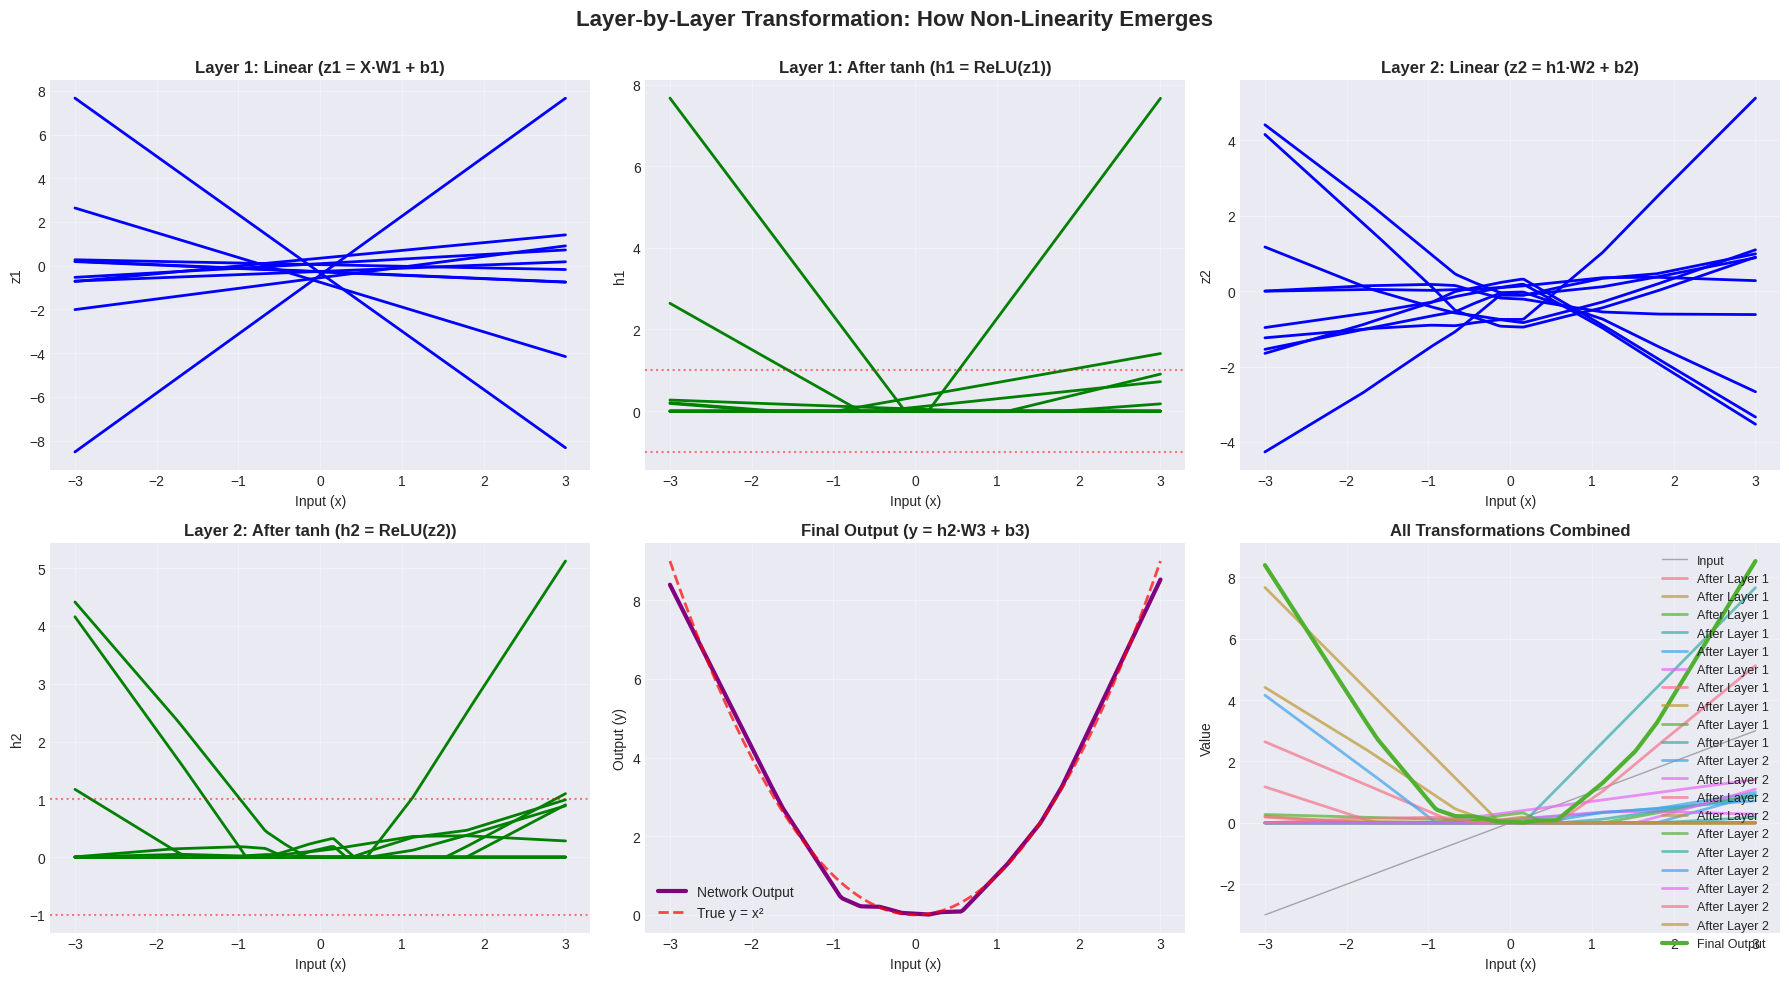


🔍 Observation:
  Each tanh activation 'warps' the signal in a non-linear way.
  The composition of these warps creates the final curved output!


In [13]:
# Get intermediate activations from non-linear network
X_demo = np.linspace(-3, 3, 200).reshape(-1, 1)

# Forward pass to get all intermediate values
z1 = X_demo @ relu_net.W1 + relu_net.b1
h1 = relu_net.relu(z1)
z2 = h1 @ relu_net.W2 + relu_net.b2
h2 = relu_net.relu(z2)
output = h2 @ relu_net.W3 + relu_net.b3

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Layer 1: Linear transformation
axes[0, 0].plot(X_demo, z1, 'b-', linewidth=2)
axes[0, 0].set_title('Layer 1: Linear (z1 = X·W1 + b1)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Input (x)')
axes[0, 0].set_ylabel('z1')
axes[0, 0].grid(True, alpha=0.3)

# Layer 1: After activation
axes[0, 1].plot(X_demo, h1, 'g-', linewidth=2)
axes[0, 1].axhline(y=1, color='r', linestyle=':', alpha=0.5)
axes[0, 1].axhline(y=-1, color='r', linestyle=':', alpha=0.5)
axes[0, 1].set_title('Layer 1: After tanh (h1 = ReLU(z1))', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Input (x)')
axes[0, 1].set_ylabel('h1')
axes[0, 1].grid(True, alpha=0.3)

# Layer 2: Linear transformation
axes[0, 2].plot(X_demo, z2, 'b-', linewidth=2)
axes[0, 2].set_title('Layer 2: Linear (z2 = h1·W2 + b2)', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Input (x)')
axes[0, 2].set_ylabel('z2')
axes[0, 2].grid(True, alpha=0.3)

# Layer 2: After activation
axes[1, 0].plot(X_demo, h2, 'g-', linewidth=2)
axes[1, 0].axhline(y=1, color='r', linestyle=':', alpha=0.5)
axes[1, 0].axhline(y=-1, color='r', linestyle=':', alpha=0.5)
axes[1, 0].set_title('Layer 2: After tanh (h2 = ReLU(z2))', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Input (x)')
axes[1, 0].set_ylabel('h2')
axes[1, 0].grid(True, alpha=0.3)

# Output layer
axes[1, 1].plot(X_demo, output, 'purple', linewidth=3, label='Network Output')
axes[1, 1].plot(X_demo, X_demo**2, 'r--', linewidth=2, alpha=0.7, label='True y = x²')
axes[1, 1].set_title('Final Output (y = h2·W3 + b3)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Input (x)')
axes[1, 1].set_ylabel('Output (y)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Summary: All transformations
axes[1, 2].plot(X_demo, X_demo, 'k-', linewidth=1, alpha=0.3, label='Input')
axes[1, 2].plot(X_demo, h1, linewidth=2, alpha=0.7, label='After Layer 1')
axes[1, 2].plot(X_demo, h2, linewidth=2, alpha=0.7, label='After Layer 2')
axes[1, 2].plot(X_demo, output, linewidth=3, label='Final Output')
axes[1, 2].set_title('All Transformations Combined', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Input (x)')
axes[1, 2].set_ylabel('Value')
axes[1, 2].legend(fontsize=9)
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('Layer-by-Layer Transformation: How Non-Linearity Emerges', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('layer_by_layer_transformation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔍 Observation:")
print("  Each tanh activation 'warps' the signal in a non-linear way.")
print("  The composition of these warps creates the final curved output!")

## 3. Visual Comparison: The Dramatic Difference

/tmp/ipython-input-4156100707.py:37: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-4156100707.py:37: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


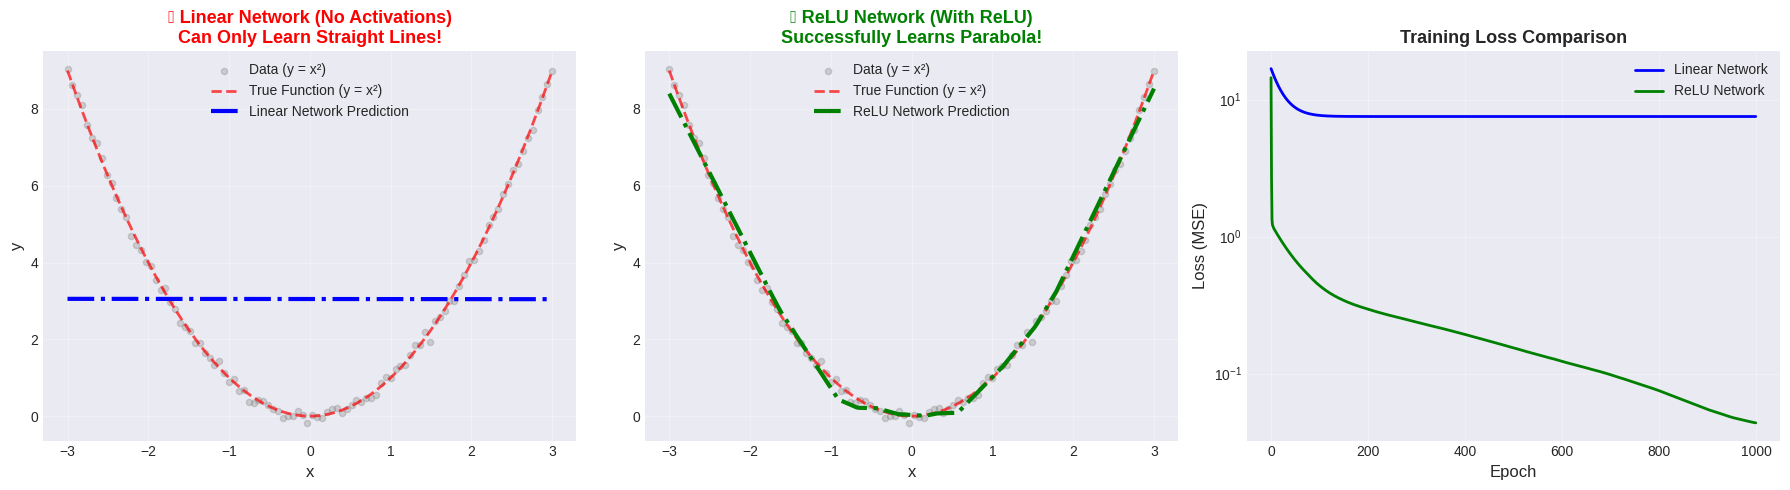


📊 Results:
  Linear Network Final Loss: 7.5303
  ReLU Network Final Loss: 0.0437
  Improvement: 172.2x better!


In [5]:
X_plot = np.linspace(-3, 3, 200).reshape(-1, 1)
y_linear = linear_net.forward(X_plot)
y_relu = relu_net.forward(X_plot)
y_true_plot = X_plot ** 2

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X, y_noisy, alpha=0.3, s=20, label='Data (y = x²)', color='gray')
axes[0].plot(X_plot, y_true_plot, 'r--', linewidth=2, label='True Function (y = x²)', alpha=0.7)
axes[0].plot(X_plot, y_linear, 'b-.', linewidth=3, label='Linear Network Prediction')
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
axes[0].set_title('❌ Linear Network (No Activations)\nCan Only Learn Straight Lines!', 
                  fontsize=13, fontweight='bold', color='red')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X, y_noisy, alpha=0.3, s=20, label='Data (y = x²)', color='gray')
axes[1].plot(X_plot, y_true_plot, 'r--', linewidth=2, label='True Function (y = x²)', alpha=0.7)
axes[1].plot(X_plot, y_relu, 'g-.', linewidth=3, label='ReLU Network Prediction')
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('y', fontsize=12)
axes[1].set_title('✅ ReLU Network (With ReLU)\nSuccessfully Learns Parabola!', 
                  fontsize=13, fontweight='bold', color='green')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

axes[2].plot(linear_losses, label='Linear Network', linewidth=2, color='blue')
axes[2].plot(relu_losses, label='ReLU Network', linewidth=2, color='green')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Loss (MSE)', fontsize=12)
axes[2].set_title('Training Loss Comparison', fontsize=13, fontweight='bold')
axes[2].set_yscale('log')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Results:")
print(f"  Linear Network Final Loss: {linear_losses[-1]:.4f}")
print(f"  ReLU Network Final Loss: {relu_losses[-1]:.4f}")
print(f"  Improvement: {(linear_losses[-1] / relu_losses[-1]):.1f}x better!")

## 4. Understanding ReLU Activation

### The ReLU Function

The Rectified Linear Unit (ReLU) is defined as:

$$\text{ReLU}(x) = \max(0, x) = \begin{cases} x & \text{if } x > 0 \\ 0 & \text{if } x \leq 0 \end{cases}$$

**Key Properties:**
- **Piecewise linear**: Linear for x > 0, zero for x ≤ 0
- **No saturation** for positive values (unlike tanh/sigmoid)
- **Sparse activation**: Outputs exactly 0 for negative inputs
- **Simple derivative**: 1 if x > 0, else 0
- **Computationally efficient**: Just a comparison and max operation

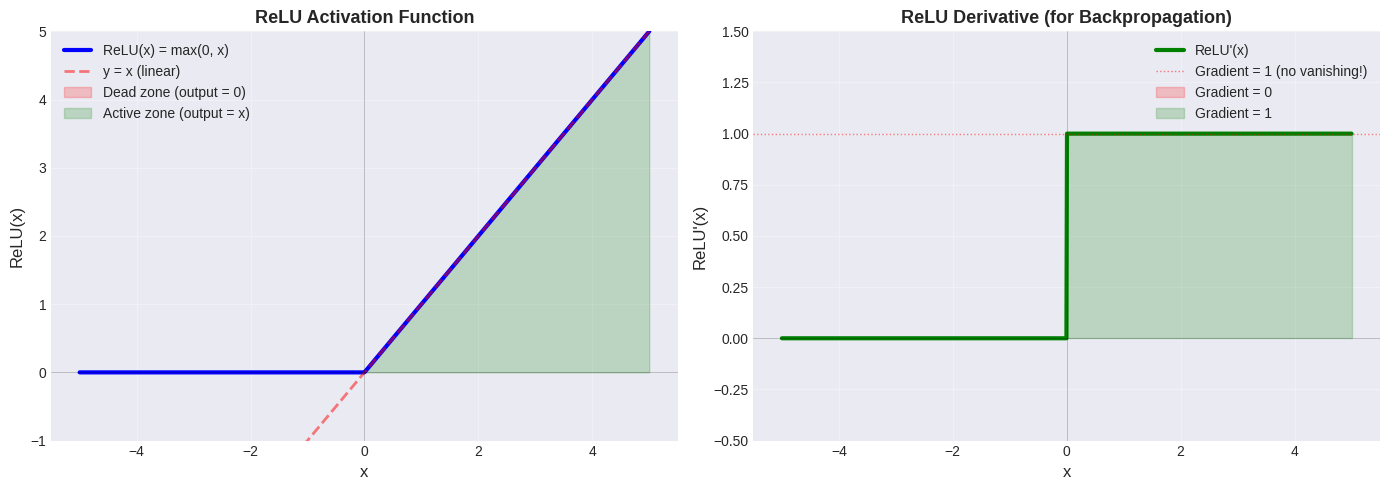


📐 ReLU Properties:
  ReLU(-5) = 0.0000 (dead)
  ReLU(0) = 0.0000 (boundary)
  ReLU(5) = 5.0000 (active, no saturation!)
  ReLU(100) = 100.0000 (still no saturation!)
  ReLU'(5) = 1.0000 (constant gradient, no vanishing!)


In [6]:
x = np.linspace(-5, 5, 1000)
relu_x = np.maximum(0, x)
relu_derivative = (x > 0).astype(float)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(x, relu_x, 'b-', linewidth=3, label='ReLU(x) = max(0, x)')
axes[0].plot(x, x, 'r--', linewidth=2, alpha=0.5, label='y = x (linear)')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0].axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0].fill_between(x, 0, relu_x, where=(x<0), alpha=0.2, color='red', label='Dead zone (output = 0)')
axes[0].fill_between(x, 0, relu_x, where=(x>=0), alpha=0.2, color='green', label='Active zone (output = x)')
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('ReLU(x)', fontsize=12)
axes[0].set_title('ReLU Activation Function', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-1, 5)

axes[1].plot(x, relu_derivative, 'g-', linewidth=3, label="ReLU'(x)")
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[1].axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[1].axhline(y=1, color='r', linestyle=':', linewidth=1, alpha=0.5, label='Gradient = 1 (no vanishing!)')
axes[1].fill_between(x, 0, relu_derivative, where=(x<0), alpha=0.2, color='red', label='Gradient = 0')
axes[1].fill_between(x, 0, relu_derivative, where=(x>=0), alpha=0.2, color='green', label='Gradient = 1')
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel("ReLU'(x)", fontsize=12)
axes[1].set_title('ReLU Derivative (for Backpropagation)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

print("\n📐 ReLU Properties:")
print(f"  ReLU(-5) = {np.maximum(0, -5):.4f} (dead)")
print(f"  ReLU(0) = {np.maximum(0, 0):.4f} (boundary)")
print(f"  ReLU(5) = {np.maximum(0, 5):.4f} (active, no saturation!)")
print(f"  ReLU(100) = {np.maximum(0, 100):.4f} (still no saturation!)")
print(f"  ReLU'(5) = {1.0:.4f} (constant gradient, no vanishing!)")

## 5. ReLU vs tanh: Saturation Behavior Demo

### Why No Saturation Matters

One of ReLU's key advantages is that it **doesn't saturate** for positive values.

**Saturation Problem:**
- tanh(x) → 1 as x → ∞ (saturates)
- tanh'(x) → 0 as x → ∞ (vanishing gradient)
- This slows down learning!

**ReLU Solution:**
- ReLU(x) = x for x > 0 (no saturation)
- ReLU'(x) = 1 for x > 0 (constant gradient)
- Faster learning and better gradient flow!

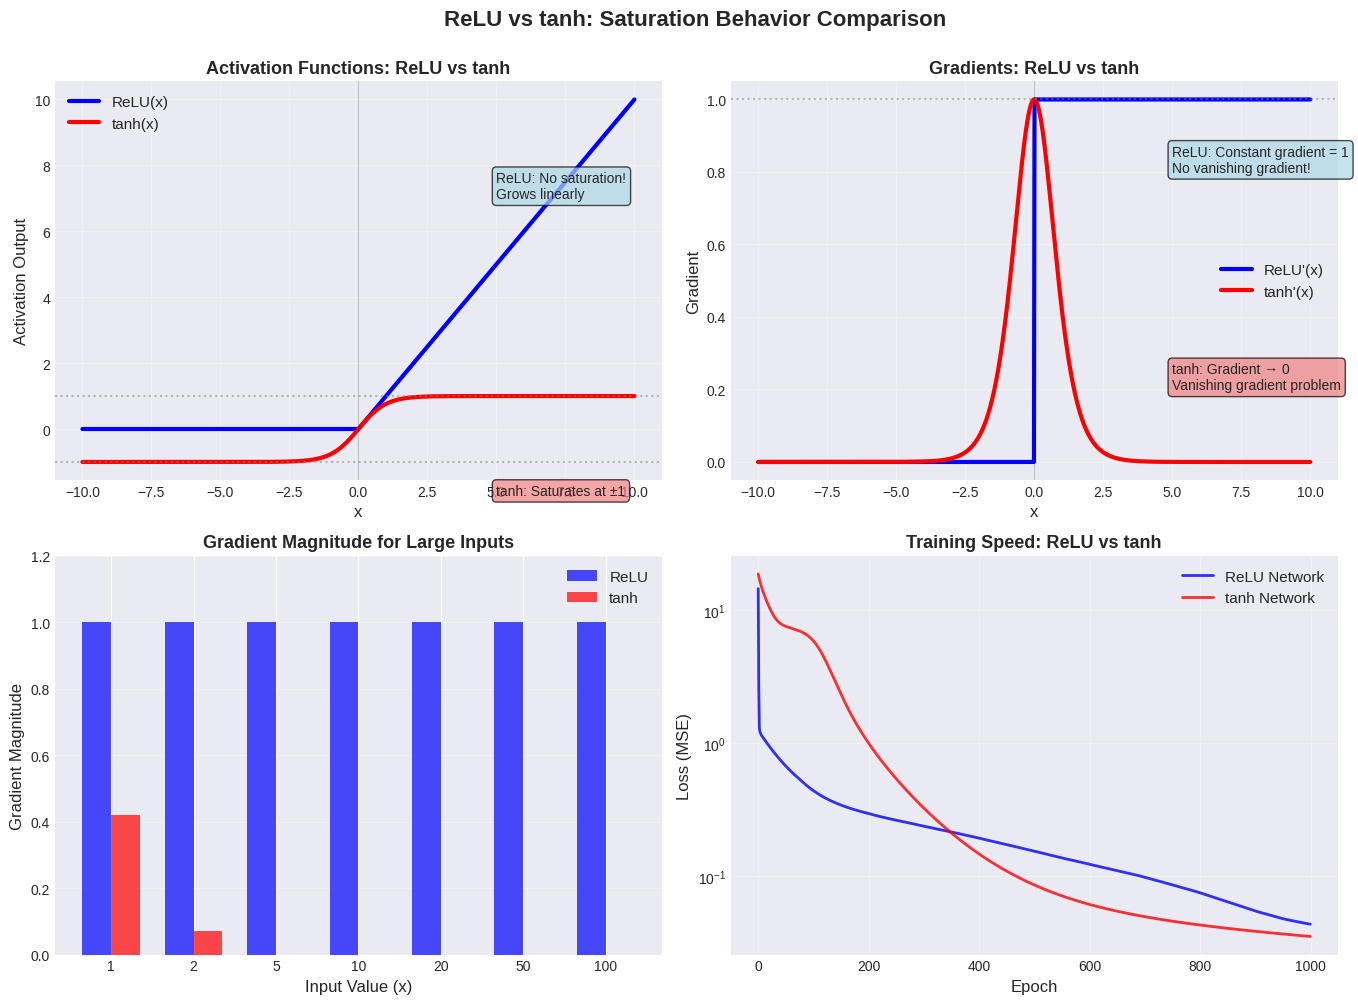


🔍 Saturation Analysis:
  For x = 10:
    ReLU(10) = 10.0000, ReLU'(10) = 1.0000
    tanh(10) = 1.0000, tanh'(10) = 0.000000

  ReLU maintains full gradient, tanh gradient vanishes!
  This is why ReLU often trains faster than tanh.


In [7]:
x_range = np.linspace(-10, 10, 1000)
relu_vals = np.maximum(0, x_range)
tanh_vals = np.tanh(x_range)
relu_grad = (x_range > 0).astype(float)
tanh_grad = 1 - np.tanh(x_range) ** 2

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(x_range, relu_vals, 'b-', linewidth=3, label='ReLU(x)')
axes[0, 0].plot(x_range, tanh_vals, 'r-', linewidth=3, label='tanh(x)')
axes[0, 0].axhline(y=1, color='gray', linestyle=':', alpha=0.5)
axes[0, 0].axhline(y=-1, color='gray', linestyle=':', alpha=0.5)
axes[0, 0].axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0, 0].set_xlabel('x', fontsize=12)
axes[0, 0].set_ylabel('Activation Output', fontsize=12)
axes[0, 0].set_title('Activation Functions: ReLU vs tanh', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(5, 7, 'ReLU: No saturation!\nGrows linearly', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
axes[0, 0].text(5, -2, 'tanh: Saturates at ±1', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

axes[0, 1].plot(x_range, relu_grad, 'b-', linewidth=3, label="ReLU'(x)")
axes[0, 1].plot(x_range, tanh_grad, 'r-', linewidth=3, label="tanh'(x)")
axes[0, 1].axhline(y=1, color='gray', linestyle=':', alpha=0.5)
axes[0, 1].axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0, 1].set_xlabel('x', fontsize=12)
axes[0, 1].set_ylabel('Gradient', fontsize=12)
axes[0, 1].set_title('Gradients: ReLU vs tanh', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(5, 0.8, 'ReLU: Constant gradient = 1\nNo vanishing gradient!', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
axes[0, 1].text(5, 0.2, 'tanh: Gradient → 0\nVanishing gradient problem', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

large_x = np.array([1, 2, 5, 10, 20, 50, 100])
relu_large_grad = (large_x > 0).astype(float)
tanh_large_grad = 1 - np.tanh(large_x) ** 2

x_pos = np.arange(len(large_x))
width = 0.35
axes[1, 0].bar(x_pos - width/2, relu_large_grad, width, label='ReLU', color='blue', alpha=0.7)
axes[1, 0].bar(x_pos + width/2, tanh_large_grad, width, label='tanh', color='red', alpha=0.7)
axes[1, 0].set_xlabel('Input Value (x)', fontsize=12)
axes[1, 0].set_ylabel('Gradient Magnitude', fontsize=12)
axes[1, 0].set_title('Gradient Magnitude for Large Inputs', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(large_x)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim(0, 1.2)

class TanhNetwork(ReLUNetwork):
    def relu(self, x):
        return np.tanh(x)
    def relu_derivative(self, x):
        return 1 - np.tanh(x) ** 2

tanh_net = TanhNetwork(learning_rate=0.01, hidden_size=10)
tanh_losses = []
for epoch in range(1000):
    y_pred = tanh_net.forward(X)
    loss = tanh_net.compute_loss(y_noisy, y_pred)
    tanh_net.backward(y_noisy, y_pred)
    tanh_losses.append(loss)

axes[1, 1].plot(relu_losses, 'b-', linewidth=2, label='ReLU Network', alpha=0.8)
axes[1, 1].plot(tanh_losses, 'r-', linewidth=2, label='tanh Network', alpha=0.8)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Loss (MSE)', fontsize=12)
axes[1, 1].set_title('Training Speed: ReLU vs tanh', fontsize=13, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('ReLU vs tanh: Saturation Behavior Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n🔍 Saturation Analysis:")
print(f"  For x = 10:")
print(f"    ReLU(10) = {np.maximum(0, 10):.4f}, ReLU'(10) = {1.0:.4f}")
print(f"    tanh(10) = {np.tanh(10):.4f}, tanh'(10) = {1 - np.tanh(10)**2:.6f}")
print(f"\n  ReLU maintains full gradient, tanh gradient vanishes!")
print(f"  This is why ReLU often trains faster than tanh.")

## 6. Sparse Activation Patterns Demo

### Why Sparse Activation Matters

ReLU creates **sparse representations** where many neurons output exactly 0.

**Benefits of Sparsity:**
1. **Computational efficiency**: Skip computations for zero activations
2. **Better feature learning**: Neurons specialize to specific input patterns
3. **Natural regularization**: Reduces overfitting
4. **Biological plausibility**: Similar to how real neurons work

**Comparison:**
- **tanh**: All neurons always active (never exactly zero)
- **ReLU**: Typically ~50% of neurons are zero (sparse)

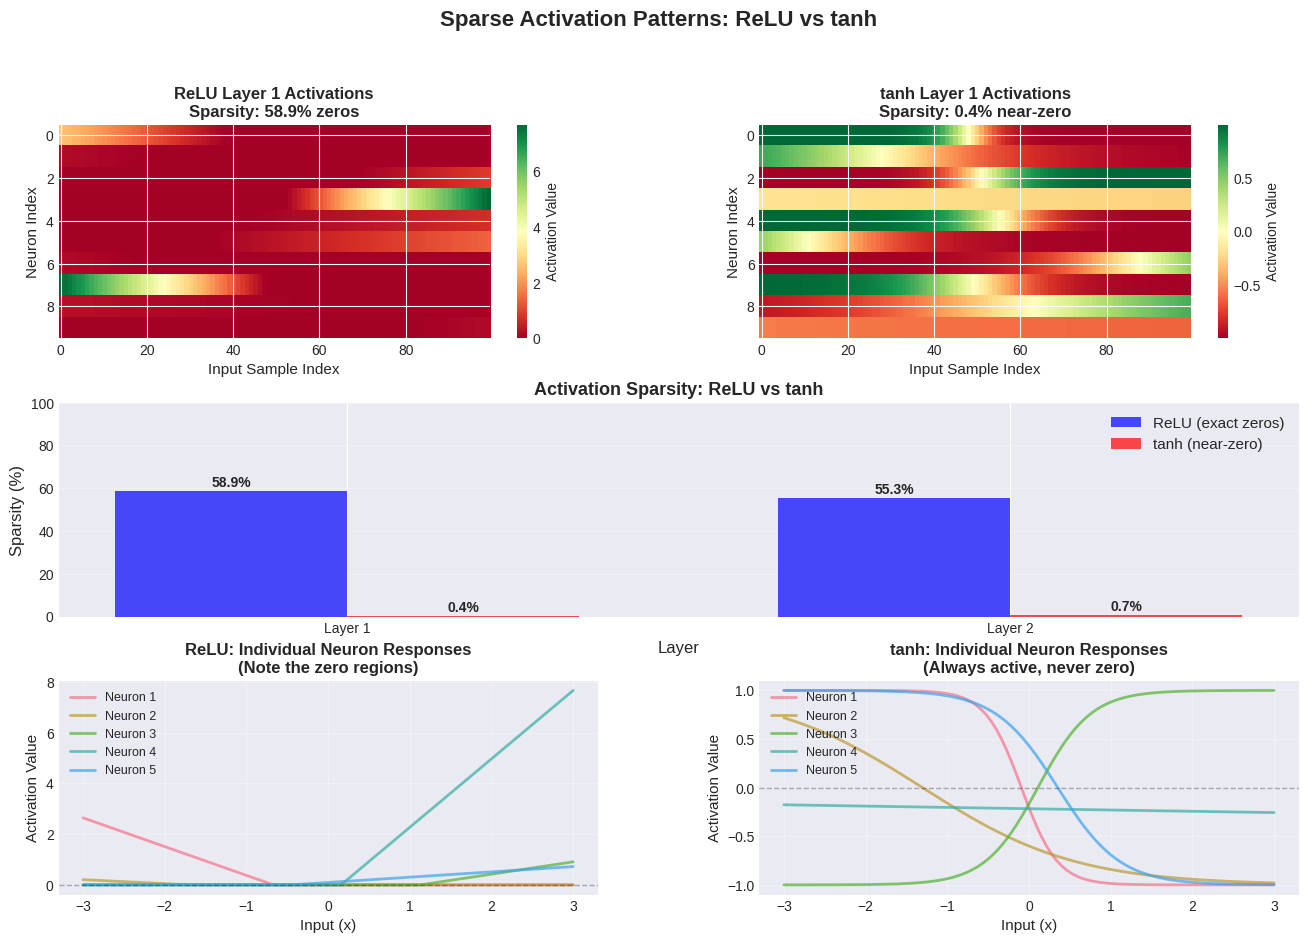


🔍 Sparsity Analysis:
  ReLU Network:
    Layer 1: 58.9% exact zeros
    Layer 2: 55.3% exact zeros

  tanh Network:
    Layer 1: 0.4% near-zero (|x| < 0.01)
    Layer 2: 0.7% near-zero (|x| < 0.01)

  Key Insight: ReLU creates true sparse representations!
  This means ~59% of computations can be skipped.


In [ ]:
X_test = np.linspace(-3, 3, 100).reshape(-1, 1)

z1_relu = X_test @ relu_net.W1 + relu_net.b1
h1_relu = np.maximum(0, z1_relu)
z2_relu = h1_relu @ relu_net.W2 + relu_net.b2
h2_relu = np.maximum(0, z2_relu)

z1_tanh = X_test @ tanh_net.W1 + tanh_net.b1
h1_tanh = np.tanh(z1_tanh)
z2_tanh = h1_tanh @ tanh_net.W2 + tanh_net.b2
h2_tanh = np.tanh(z2_tanh)

# ReLU Sparsity (exact zeros)
relu_sparsity_l1 = np.mean(h1_relu == 0) * 100
relu_sparsity_l2 = np.mean(h2_relu == 0) * 100
# Explanation:
# - h1_relu == 0 creates a boolean array: [True, False, True, ...] where True = zero
# - np.mean() counts True as 1, False as 0, then averages
# - Result: fraction of zeros (e.g., 0.45 = 45% are zero)
# - * 100 converts to percentage


# tanh Sparsity (near-zero, since tanh never outputs exact zero)
tanh_sparsity_l1 = np.mean(np.abs(h1_tanh) < 0.01) * 100
tanh_sparsity_l2 = np.mean(np.abs(h2_tanh) < 0.01) * 100
# Explanation:
# - np.abs(h1_tanh) gets absolute values: [-0.5, 0.003, 0.8] → [0.5, 0.003, 0.8]
# - < 0.01 checks if "close to zero": [False, True, False]
# - np.mean() calculates percentage of near-zero values
# - Threshold 0.01 is arbitrary (1% of tanh's range)


fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(h1_relu.T, aspect='auto', cmap='RdYlGn', interpolation='nearest')
ax1.set_xlabel('Input Sample Index', fontsize=11)
ax1.set_ylabel('Neuron Index', fontsize=11)
ax1.set_title(f'ReLU Layer 1 Activations\nSparsity: {relu_sparsity_l1:.1f}% zeros', 
              fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=ax1, label='Activation Value')

ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(h1_tanh.T, aspect='auto', cmap='RdYlGn', interpolation='nearest')
ax2.set_xlabel('Input Sample Index', fontsize=11)
ax2.set_ylabel('Neuron Index', fontsize=11)
ax2.set_title(f'tanh Layer 1 Activations\nSparsity: {tanh_sparsity_l1:.1f}% near-zero', 
              fontsize=12, fontweight='bold')
plt.colorbar(im2, ax=ax2, label='Activation Value')

ax3 = fig.add_subplot(gs[1, :])
categories = ['Layer 1', 'Layer 2']
relu_sparsities = [relu_sparsity_l1, relu_sparsity_l2]
tanh_sparsities = [tanh_sparsity_l1, tanh_sparsity_l2]

x_pos = np.arange(len(categories))
width = 0.35
ax3.bar(x_pos - width/2, relu_sparsities, width, label='ReLU (exact zeros)', 
        color='blue', alpha=0.7)
ax3.bar(x_pos + width/2, tanh_sparsities, width, label='tanh (near-zero)', 
        color='red', alpha=0.7)
ax3.set_xlabel('Layer', fontsize=12)
ax3.set_ylabel('Sparsity (%)', fontsize=12)
ax3.set_title('Activation Sparsity: ReLU vs tanh', fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(categories)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim(0, 100)

for i, (r, t) in enumerate(zip(relu_sparsities, tanh_sparsities)):
    ax3.text(i - width/2, r + 2, f'{r:.1f}%', ha='center', fontsize=10, fontweight='bold')
    ax3.text(i + width/2, t + 2, f'{t:.1f}%', ha='center', fontsize=10, fontweight='bold')

ax4 = fig.add_subplot(gs[2, 0])
for i in range(min(5, h1_relu.shape[1])):
    ax4.plot(X_test, h1_relu[:, i], linewidth=2, alpha=0.7, label=f'Neuron {i+1}')
ax4.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.3)
ax4.set_xlabel('Input (x)', fontsize=11)
ax4.set_ylabel('Activation Value', fontsize=11)
ax4.set_title('ReLU: Individual Neuron Responses\n(Note the zero regions)', 
              fontsize=12, fontweight='bold')
ax4.legend(fontsize=9, loc='upper left')
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[2, 1])
for i in range(min(5, h1_tanh.shape[1])):
    ax5.plot(X_test, h1_tanh[:, i], linewidth=2, alpha=0.7, label=f'Neuron {i+1}')
ax5.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.3)
ax5.set_xlabel('Input (x)', fontsize=11)
ax5.set_ylabel('Activation Value', fontsize=11)
ax5.set_title('tanh: Individual Neuron Responses\n(Always active, never zero)', 
              fontsize=12, fontweight='bold')
ax5.legend(fontsize=9, loc='upper left')
ax5.grid(True, alpha=0.3)

plt.suptitle('Sparse Activation Patterns: ReLU vs tanh', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n🔍 Sparsity Analysis:")
print(f"  ReLU Network:")
print(f"    Layer 1: {relu_sparsity_l1:.1f}% exact zeros")
print(f"    Layer 2: {relu_sparsity_l2:.1f}% exact zeros")
print(f"\n  tanh Network:")
print(f"    Layer 1: {tanh_sparsity_l1:.1f}% near-zero (|x| < 0.01)")
print(f"    Layer 2: {tanh_sparsity_l2:.1f}% near-zero (|x| < 0.01)")
print(f"\n  Key Insight: ReLU creates true sparse representations!")
print(f"  This means ~{relu_sparsity_l1:.0f}% of computations can be skipped.")

## 7. Summary: How ReLU Enables Non-Linearity

### The Complete Picture

| Aspect | Without Activations | With ReLU |
|--------|-------------------|------------------|  
| **Mathematical Form** | y = X·W_combined + b | y = W₃·ReLU(W₂·ReLU(W₁·X + b₁) + b₂) + b₃ |
| **Simplification** | ✅ Collapses to linear | ❌ Cannot simplify |
| **Function Class** | Linear only | Any continuous function |
| **Can learn x²?** | ❌ No | ✅ Yes |
| **Saturation** | N/A | ❌ No (for x > 0) |
| **Sparsity** | N/A | ✅ Yes (~50% zeros) |
| **Gradient Flow** | N/A | ✅ Constant (no vanishing) |

### Key Insights

1. **Piecewise Linear Approximation**: ReLU creates hinges that approximate curves
2. **No Saturation**: ReLU(x) = x for x > 0, maintaining full gradient
3. **Sparse Activation**: ~50% of neurons are zero, improving efficiency
4. **Composition Creates Complexity**: Multiple ReLU layers build non-linear functions
5. **Universal Approximation**: With enough neurons, ReLU networks can learn any function

### The Answer

**Q**: How can neural networks learn x²?

**A**: ReLU activation prevents layer collapse by introducing piecewise linearity. Each ReLU unit creates a hinge, and combining multiple hinges approximates smooth curves. Unlike tanh, ReLU doesn't saturate for positive values and creates sparse representations, making it both powerful and efficient!

---

**🎓 Congratulations!** You now understand how ReLU enables non-linear learning through its unique properties of piecewise linearity, no saturation, and sparse activation!